Epoch 1/10
300/300 [==============================] - 2s 4ms/step - loss: 0.5302 - accuracy: 0.8529
Epoch 2/10
300/300 [==============================] - 1s 4ms/step - loss: 0.2894 - accuracy: 0.9183
Epoch 3/10
300/300 [==============================] - 1s 4ms/step - loss: 0.2606 - accuracy: 0.9248
Epoch 4/10
300/300 [==============================] - 1s 4ms/step - loss: 0.2455 - accuracy: 0.9302
Epoch 5/10
300/300 [==============================] - 1s 4ms/step - loss: 0.2363 - accuracy: 0.9326
Epoch 6/10
300/300 [==============================] - 1s 4ms/step - loss: 0.2305 - accuracy: 0.9336
Epoch 7/10
300/300 [==============================] - 1s 5ms/step - loss: 0.2264 - accuracy: 0.9354
Epoch 8/10
300/300 [==============================] - 1s 5ms/step - loss: 0.2227 - accuracy: 0.9364
Epoch 9/10
300/300 [==============================] - 1s 5ms/step - loss: 0.2198 - accuracy: 0.9372
Epoch 10/10
75/75 [==============================] - 0s 2ms/step - loss: 0.3565 - accuracy: 0.9042



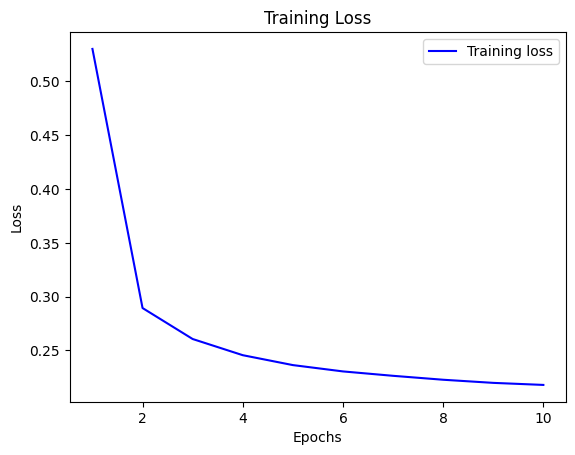

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import precision_recall_fscore_support
from keras.utils import to_categorical
import tensorflow as tf

file_path = r'D:\Research\Python\Notebooks\Final Notebooks\Training Data\Manually_Annotated_data_new.csv'
df = pd.read_csv(file_path, encoding='UTF-8', engine='python')

# Mapping sentiment labels to numerical values
Labelled_sentiment = {
    -1: 0,   # negative sentiment
    0: 1,    # neutral sentiment
    1: 2     # positive sentiment
}

# Update the 'Labelled_sentiment' column in the DataFrame
df['Labelled_sentiment'] = df['Labelled_sentiment'].map(Labelled_sentiment)

X = df['Preprocessed_Text'].astype(str)  # Features
y_true = df['Labelled_sentiment']  # True Labels
y_true = np.nan_to_num(y_true, nan=0)  # Replace NaN values with 0 for neutral sentiment

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.2, random_state=42)

# Create and fit the TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Convert true labels to categorical format
y_train_categorical = to_categorical(y_train, num_classes=3)
y_test_categorical = to_categorical(y_test, num_classes=3)

# Convert TfidfVectorizer output to dense arrays
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

# Convert dense arrays to SparseTensors
X_train_tfidf_sparse = tf.sparse.from_dense(X_train_tfidf_dense)
X_test_tfidf_sparse = tf.sparse.from_dense(X_test_tfidf_dense)

# Reorder the SparseTensor to ensure sorted indices
X_train_tfidf_sparse = tf.sparse.reorder(X_train_tfidf_sparse)
X_test_tfidf_sparse = tf.sparse.reorder(X_test_tfidf_sparse)

# Create the DNN model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_tfidf.shape[1],)))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the sentiment analysis task
history = model.fit(X_train_tfidf_sparse, y_train_categorical, epochs=10, batch_size=32, verbose=1)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_tfidf_sparse, y_test_categorical)
print("\nTesting Set:")
print("Loss:", loss)
print("Accuracy:", accuracy)

# Make predictions on test data
y_pred = model.predict(X_test_tfidf_sparse)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

# Display loss and accuracy during training
import matplotlib.pyplot as plt

train_loss = history.history['loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
